# Assignment 4: Discrete time models
## [Scientific Computing with Python](https://scicompy.yoavram.com/)
## Yoav Ram

In [1]:
import random

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
sns.set_context('notebook')
colors = sns.color_palette('Set1', 3)
sns.set_palette('Set1')
np.set_printoptions(suppress=True)

# General instructions

1. When instructed to implement a function, use the given function names and parameters lists; failure to do so may cause test functions to fail during grading.
1. When instructed to generate a plot, make sure that the plot is clear, that axes are propely labeled, and that the notebook is saved with the plot inline, so that the grader can see the plot without running the code. Make sure that you re-generate the plot if you changed the code!
1. Code lines with a triple comment `###` should not be removed or modified, they are used for automatic grading.
1. Note that the last cell in the notebook says **end of assignment**; if you are missing anything please download the origianl file from the course website.
1. This exercise doesn't put much emphasis on efficieny or runtime. *But*, your code should still run within a reasonable time (a few minutes) and you should use idioms learned in class, e.g. array opreations, wherever possible to "lose your loops".
1. Questions regarding the exercises should be posted to the course forum at the designated group (i.e. "assignment 4"). You can post questions anonymously. You can also visit the Office Hours, but please do not email the course staff with questions about the exercise.
1. Intructions for submitting the exercise are on the [course website](https://scicompy.yoavram.com/assignments).

# Exercise 1

In this exercise we'll model the spread of an infectious disease that spreads by contact with an infected individual.
Infected individuals remain infected for some time and then become recovered, and thereby they cannot be infected again, nor are they infecting anymore.

This is the [classic SIR model](https://royalsocietypublishing.org/doi/abs/10.1098/rspa.1927.0118), where $S$ stands for *susceptible*, $I$ stands for *infected*, and $R$ stands for *recovered*. The total population size is $N=S+I+R$.

It would get really overwhelming if you had to ask every person at *every point in time*: "Are you sick yet? Did you get better yet?".
It makes more sense to monitor individuals' states on a *discrete basis* rather than continuously, for example, *once a day*. 

Susceptible individuals meet $c$ individuals every day, of which $I/N$ are infected. When meeting an infected individual, they become infected with probability $b$.  Thus, on average $\beta S I/N$ susceptible individuals become infected every day, where $\beta=b \cdot c$ is the transmission rate.
On average, $\gamma I$ infected individuals recover every day, hence $\gamma$ is the recovery rate.

Therefore, we can describe the model using the following equations:
$$
\mathbf{E}[S_{t+1} \mid I_t, S_t] = S_t - \beta S_t \frac{I_t}{N} \\
\mathbf{E}[I_{t+1} \mid I_t, S_t] = I_t + \beta S_t \frac{I_t}{N} - \gamma I_t \\
\mathbf{E}[R_{t+1} \mid I_t, R_t] = R_t + \gamma I_t \\
$$

Say that you start with a population of 1000 people, and only 10 infected individuals (the rest are susceptible).
That means your "initial state" is $S=990, I=10, R=0$, i.e. 990 are susceptible, 10 is infected, and 0 are recovered.

In [2]:
###
SIR0 = 990, 10, 0
β=1.1
γ=0.5

**Implement a function called `step(SIR, β, γ)`** that given the current state `SIR=(S, I, R)` and the parameters $\gamma$ and $\beta$, randomly generates the next state.

Think: how would you implement the random draws? Which distribution is parameterized by its expected values?

Note: you should make sure that $S$, $I$, and $R$ are integers and that they don't go below 0 or above $N$.


In [3]:
def step_poisson(SIR, β, γ):
    S, I, R = SIR
    N = S + I + R
    
    infected = β * S * I / N
    recovered = γ * I
    
    λ = np.array([infected, recovered])
    λ[λ < 0] = 0
    infected, recovered = λ
    
    Δinfected, Δrecovered = np.random.poisson(lam=[infected, recovered])
    
    S -= Δinfected
    R += Δrecovered
    I += Δinfected - Δrecovered

    SIR = np.array([S, I, R])
    SIR = (SIR / SIR.sum() * N).round()
    S, I, R = SIR
    
    return S, I, R
step_poisson(SIR0, β, γ)

(979.0, 14.0, 7.0)

In [4]:
def step_binom(SIR, β, γ):
    S, I, R = SIR
    N = S + I + R
    
    p =  β * I / N
    if p >= 1:
        p = 1
        
    inf = np.random.binomial(S, p)
    rec = np.random.binomial(I, γ)
    
    S -= inf
    I += inf - rec
    R += rec
    
    return S, I, R

step_binom(SIR0, β, γ)

(976, 20, 4)

In [6]:
step = step_poisson if input('which step (p/b)?') == 'p' else step_binom

step.__name__

which step (p/b)? p


'step_poisson'

**Implement a function called `simulation(SIR0, β, γ, days)`** that given an initial state `SIR0=(S0, I0, R0)`, parameters $\gamma$ and $\beta$, and the number of days $days$ to run the simulation, simulates the dynamics and returns a vector `SIR` in which the value at index `t, j` gives state `j` at day `t` (`j` being 0 for $S$, 1 for $I$, and 2 for $R$). 

Note that you should call `step` from `simulation`.

Think: What is the type of the returned value? How many dimensions does it have?

In [7]:
def simulation(SIR0, β, γ, days): ###
    sim = np.empty((days,3))
    S, I, R = SIR0
    for i in range(days):
        sim[i] = S, I ,R 
        S, I, R = step(sim[i], β, γ)

    return sim
    
print(simulation(SIR0, β, γ, days=10)) ###

[[990.  10.   0.]
 [982.  13.   5.]
 [966.  24.  10.]
 [935.  44.  21.]
 [887.  68.  45.]
 [825.  98.  77.]
 [729. 155. 116.]
 [614. 191. 195.]
 [492. 219. 289.]
 [375. 215. 410.]]


**Run and plot** the dynamics for 30 days.

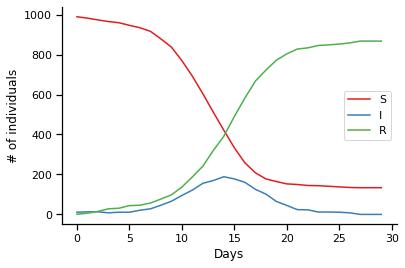

In [8]:
S, I, R = simulation(SIR0, β, γ, 30).T

plt.plot(S, label='S')
plt.plot(I, label='I')
plt.plot(R, label='R')
plt.xlabel('Days')
plt.ylabel('# of individuals')
plt.legend()
sns.despine()

We want to estimate $I_{max}$, the maximum number of infected individuals.

**Re-implement, if neccessary, the functions `step` and `simulation`** so that you can run _multiple_ simulations in one function call; this would require adding a new parameter for the number of replications (`reps`).

In [9]:
def simulation(SIR0, β, γ, days, reps): 
    # your code here
    sim = np.empty((reps, days, 3))
    
    for rep in range(reps):
        S, I, R = SIR0
        
        for day in range(days):
            sim[rep, day] = S, I, R
            S, I, R = step(sim[rep, day], β, γ)
            
    return sim

SIR = simulation(SIR0, β, γ, 30, 100) ###

**Plot the dynamics of multiple simulations.**

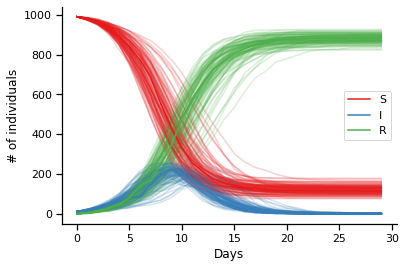

In [10]:
for rep in range(SIR.shape[0]):
    S, I, R = SIR[rep].T
    plt.plot(S, c=colors[0], alpha=0.2, label=('S' if rep == SIR.shape[0] - 1 else None))
    plt.plot(I, c=colors[1], alpha=0.2, label=('I' if rep == SIR.shape[0] - 1 else None))
    plt.plot(R, c=colors[2], alpha=0.2, label=('R' if rep == SIR.shape[0] - 1 else None))

[handle.set_alpha(1) for handle in plt.gca().get_legend_handles_labels()[0]]
plt.legend()
plt.xlabel('Days')
plt.ylabel('# of individuals') 
sns.despine()


**Add to the previous plot lines for the average dynamics** -- averaging across replications for each type and day.

Use at least 100 replications for this plot.

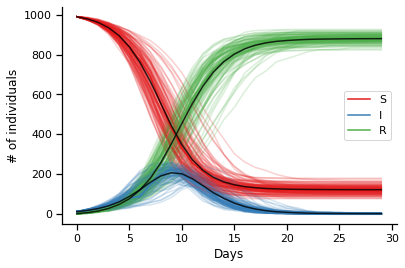

In [11]:
avg_dynamics = SIR.mean(axis=0)

for rep in range(SIR.shape[0]):
    S, I, R = SIR[rep].T
    plt.plot(S, c=colors[0], alpha=0.2, label=('S' if rep == SIR.shape[0] - 1 else None))
    plt.plot(I, c=colors[1], alpha=0.2, label=('I' if rep == SIR.shape[0] - 1 else None))
    plt.plot(R, c=colors[2], alpha=0.2, label=('R' if rep == SIR.shape[0] - 1 else None))
    
plt.plot(avg_dynamics, '-k', alpha=0.8)
[handle.set_alpha(1) for handle in plt.gca().get_legend_handles_labels()[0]]
plt.legend()
plt.xlabel('Days')
plt.ylabel('# of individuals') 
sns.despine()

**Print the $I_{max}$ and $T_{max}$**: the expected maximum number of infected individuals, that is, the maximum number of individuals in the average `I` array, and the time at which this max occurs.


In [12]:
I_max = avg_dynamics[:,1].max()
T_max = avg_dynamics[:,1].argmax()

print('I_max = ', I_max) ###
print('T_max = ', T_max) ###

I_max =  205.4
T_max =  9


**Repeat the previous plot** (dynamics + average) and add a vertical line for $T_{max}$ and a horizontal line for $I_{max}$ (using `plt.axvline` and `axhline`).

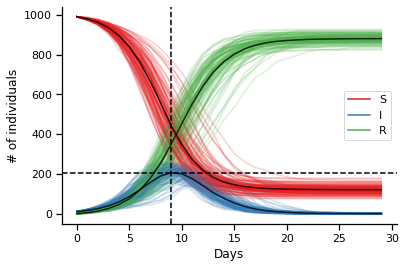

In [13]:
for rep in range(SIR.shape[0]):
    S, I, R = SIR[rep].T
    plt.plot(S, c=colors[0], alpha=0.2, label=('S' if rep == SIR.shape[0] - 1 else None))
    plt.plot(I, c=colors[1], alpha=0.2, label=('I' if rep == SIR.shape[0] - 1 else None))
    plt.plot(R, c=colors[2], alpha=0.2, label=('R' if rep == SIR.shape[0] - 1 else None))
    
plt.plot(avg_dynamics, '-k', alpha=0.8)
[handle.set_alpha(1) for handle in plt.gca().get_legend_handles_labels()[0]]
plt.legend()
plt.xlabel('Days')
plt.ylabel('# of individuals') 

plt.axvline(x=T_max, c='k', ls='--')
plt.axhline(y=I_max, c='k', ls='--')
sns.despine()

For every $\beta, \gamma$ combination there is an expected maximum number of infected individuals $I_{max}$. 

**Plot $I_{max}$ as a function of $\beta$**.

**Add a vertical line** for $\beta=\gamma$.
Epidemiological theory suggest that $R_0=\beta/\gamma$ is the reproductive number of an infectious disease. When $R_0<1$, the disease will die without infecting much of the population, whereas when $R_0>1$ the disease will become an epidemic, or even a pandemic, and will infect a significant fraction of the population.

In [64]:
βs = np.linspace(0, 2, 100)
Is = []

for β in βs:
    SIR = simulation(SIR0, β, γ, 30, 100)
    avg_dynamics = SIR.mean(axis=0)
    Is.append(avg_dynamics[:,1].max())


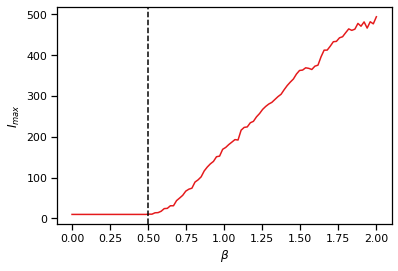

In [65]:
plt.plot(βs, Is)
plt.axvline(x=γ, c='k', ls='--')
plt.xlabel(r'$\beta$')
plt.ylabel('$I_{max}$');

**End of assignment**